<a href="https://colab.research.google.com/github/Abby263/TSAI_EVA_8/blob/main/Session_2.5/EVA_Session_2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from torchvision.transforms import transforms

from torch.utils.data import Dataset, DataLoader

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

# torchvision.datasets.MNIST outputs a set of PIL images
# Load and transform data
MNIST_train = torchvision.datasets.MNIST('/tmp', train=True, download=True, transform=transform)
MNIST_trainset, MNIST_valset = torch.utils.data.random_split(MNIST_train, [55000, 5000])
MNIST_testset = torchvision.datasets.MNIST('/tmp', train=False, download=True, transform=transform)

class RMNISTDataset(Dataset):
  def __init__(self, mnist_data):
    self.mnist_dataset = mnist_data

  def __len__(self):
    return len(self.mnist_dataset)

  def __getitem__(self, idx):
    image, label = self.mnist_dataset[idx]
    random_number = torch.randint(0, 10, size=(1,)).long()
    return image, label, random_number

The number of images in train dataset - 55000
The number of images in val dataset - 5000
The number of images in test dataset - 10000
Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])
labels: tensor([3, 4, 7, 7, 2, 8, 5, 7, 2, 7, 1, 3, 3, 1, 7, 1, 0, 2, 9, 0, 9, 5, 6, 3,
        2, 9, 7, 5, 7, 8, 9, 5])


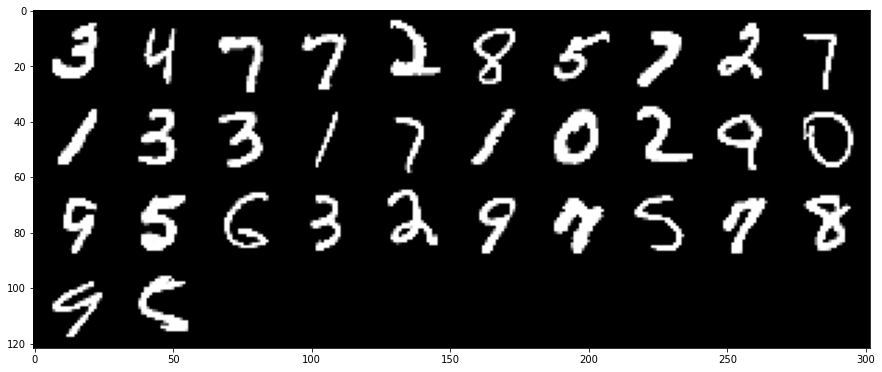

In [ ]:
# Create an instance of the MNISTDataset class
train_dataset = RMNISTDataset(MNIST_trainset)
val_dataset = RMNISTDataset(MNIST_valset)
test_dataset = RMNISTDataset(MNIST_testset)

print(f'The number of images in train dataset - {len(train_dataset)}')
print(f'The number of images in val dataset - {len(val_dataset)}')
print(f'The number of images in test dataset - {len(test_dataset)}')

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

batch = next(iter(train_loader))
images, labels, rand_num = batch 

print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")

grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

print('labels:', labels)

In [ ]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3) 
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
    self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3)
    self.fc1 = nn.Linear(in_features=1024 * 7 * 7, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.fc3 = nn.Linear(in_features=10, out_features=120)
    self.fc4 = nn.Linear(in_features=120, out_features=60)
    self.out1 = nn.Linear(in_features=60, out_features=10)
    self.out2 = nn.Linear(in_features=60, out_features=19)
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, t, r):
    # input layer
    x = t
    # conv1 layer
    x = F.relu(self.conv1(x)) # (28, 28, 1) --> (26, 26, 32) RF : 3x3
    # conv2 layer
    x = F.relu(self.conv2(x)) # (26, 26, 32) --> (24, 24, 64) RF : 5x5
    # conv3 layer
    x = F.relu(self.conv3(x)) # (24, 24, 64) --> (22, 22, 128) RF : 7x7
    # conv4 layer
    x = F.relu(self.conv4(x)) # (22, 22, 128) --> (20, 20, 256) RF : 9x9
    # conv5 layer
    x = F.relu(self.conv5(x)) # (20, 20, 256) --> (18, 18, 512) RF : 11x11
    x = F.max_pool2d(x, kernel_size=2, stride=2) # (18, 18, 512)  --> (9, 9, 512) RF : 22X22
    # conv6 layer
    x = F.relu(self.conv6(x)) # (9, 9, 512) --> (7, 7, 1024) RF : 24X24
    # reshape
    x = x.reshape(-1, 1024 * 7 * 7)
    # fc1 layer
    x = self.fc1(x)
    # fc2 layer
    x = self.fc2(x)
    # output layer 1
    x = self.out1(x)
    # fc3 layer
    sum_output = self.fc3(r.to(torch.float32))
    # fc4 layer
    sum_output = self.fc4(sum_output)
    # output layer 2
    sum_predict = self.out2(sum_output)
    return F.log_softmax(x, dim=1), F.log_softmax(sum_predict, dim=1)

network = Network()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
network.eval()

Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=50176, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=10, out_features=120, bias=True)
  (fc4): Linear(in_features=120, out_features=60, bias=True)
  (out1): Linear(in_features=60, out_features=10, bias=True)
  (out2): Linear(in_features=60, out_features=19, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(network):,} trainable parameters')
     

The model has 12,326,465 trainable parameters


In [ ]:
def train(model, train_loader, optimizer, num_epochs, device):

  model = model.train()
  for epoch in range(num_epochs):

      total_loss_mnist = 0
      total_loss_sum = 0

      for batch in train_loader: # Get Batch
          images, labels, rand_num = batch 
          images, labels, rand_num = images.to(device), labels.to(device), rand_num.to(device)

          rand_num_onehot = F.one_hot(rand_num, num_classes = 10).view(rand_num.size(0), -1)
          rand_num_onehot = rand_num_onehot.to(device)
        
          preds, sum_preds = network(images, rand_num_onehot) # Pass Batch
          preds, sum_preds = preds.to(device), sum_preds.to(device) 

          sum_labels = (preds.argmax(dim=1) + rand_num.squeeze())

          loss_mnist = F.nll_loss(preds, labels) # Calculate Loss
          loss_sum = F.nll_loss(sum_preds, sum_labels) # Calculate Loss
          loss = loss_mnist + loss_sum

          optimizer.zero_grad()
          loss.backward() # Calculate Gradients
          optimizer.step() # Update Weights

          total_loss_mnist += loss_mnist.item()

          total_loss_sum += loss_sum.item()

      print(
          "epoch", epoch, 
          "loss mnist :", total_loss_mnist,
          "loss sum:", total_loss_sum
      )

  return loss


def test(model, test_loader, device):

  model = model.eval()

  total_correct_mnist = 0
  total_correct_sum = 0

  # turn off gradients during the testing
  with torch.no_grad():

    for batch in test_loader: # Get Batch
        images, labels, rand_num = batch 
        images, labels, rand_num = images.to(device), labels.to(device), rand_num.to(device)

        rand_num_onehot = F.one_hot(rand_num, num_classes = 10).view(rand_num.size(0), -1)
        rand_num_onehot = rand_num_onehot.to(device)
      
        preds, sum_preds = network(images, rand_num_onehot) # Pass Batch
        preds, sum_preds = preds.to(device), sum_preds.to(device) 

        sum_labels = (preds.argmax(dim=1) + rand_num.squeeze())

        loss_mnist = F.nll_loss(preds, labels) # Calculate Loss
        loss_sum = F.nll_loss(sum_preds, sum_labels) # Calculate Loss
        loss = loss_mnist + loss_sum

        total_loss_mnist += loss_mnist.item()
        total_correct_mnist += get_num_correct(preds, labels)

        total_loss_sum += loss_sum.item()
        total_correct_sum += get_num_correct(sum_preds, sum_labels)

    print( 
        "loss mnist :", total_loss_mnist,
        "loss sum:", total_loss_sum,
        "total_correct_mnist :", total_correct_mnist,
        "total_correct_sum :", total_correct_sum
    )
    
  return loss

In [ ]:
# move the model to the specified device
network = network.to(device)

# use Stochastic Gradient Descent as the optimizer
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.7)

# set the number of epochs to train for
num_epoch = 25

train_loss_values = []
valid_loss_values = []

# run it for epoch number of times
for epoch in range(1, num_epoch+1):
    print('\nEpoch {} : '.format(epoch))
    # train the model
    train_loss = train(network, train_loader, optimizer, epoch, device)
    valid_loss = test(network, val_loader, device)
    # test the model
    train_loss_values.append(train_loss)
    valid_loss_values.append(valid_loss)

epoch 0 loss mnist : 118.1806766957161 loss sum: 4034.01966714859
epoch 1 loss mnist : 71.76243010921462 loss sum: 3994.3978826999664
epoch 2 loss mnist : 53.35788793210668 loss sum: 3986.907101392746
